# Computer Vision


| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

#  Importing Pytorch

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.9.1+cpu


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#  Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


yes, the dataset is downloaded and it have 3 type of image `pizza` `sushi` `steak` having train and test class
train class have 75 images and test class have an 25 images

In [4]:
# setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

lets vizulize an image

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


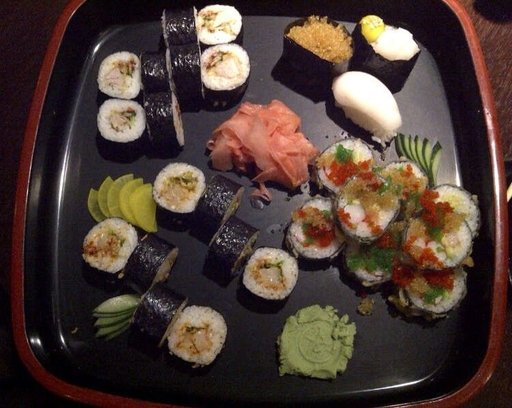

In [5]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# Transforming the Data

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

Turn it into tensors (numerical representations of our images).

Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader for short.

There are several data set problem since we are looking for an image we will use `TorchVision`

In [6]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms

##  Transforming data with `torchvision.transforms`


To get experience with torchvision.transforms, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.
4. We can compile all of these steps using `torchvision.transforms.Compose()`.

In [7]:
data_transform = transforms.Compose([
    # resize the image to 100 * 100
    transforms.Resize(size=(100,100)),
    # turn image to tensor
    transforms.ToTensor(),
    # flip the image randomly
    transforms.RandomHorizontalFlip(p=0.5),  # 50 % chance of probablities
])

In [8]:
data_transform(img)

tensor([[[0.1255, 0.1373, 0.1333,  ..., 0.0784, 0.0824, 0.0824],
         [0.1294, 0.1333, 0.1412,  ..., 0.0824, 0.0824, 0.0863],
         [0.1255, 0.1255, 0.1412,  ..., 0.0902, 0.0863, 0.0902],
         ...,
         [0.0235, 0.0275, 0.0275,  ..., 0.1373, 0.1373, 0.1294],
         [0.0275, 0.0314, 0.0314,  ..., 0.1412, 0.1333, 0.1255],
         [0.0314, 0.0314, 0.0314,  ..., 0.1255, 0.1255, 0.1255]],

        [[0.0510, 0.0588, 0.0588,  ..., 0.0392, 0.0471, 0.0431],
         [0.0667, 0.0588, 0.0549,  ..., 0.0431, 0.0392, 0.0392],
         [0.0588, 0.0510, 0.0510,  ..., 0.0431, 0.0353, 0.0314],
         ...,
         [0.0118, 0.0078, 0.0078,  ..., 0.0706, 0.0706, 0.0627],
         [0.0118, 0.0118, 0.0157,  ..., 0.0745, 0.0745, 0.0706],
         [0.0118, 0.0118, 0.0157,  ..., 0.0627, 0.0667, 0.0706]],

        [[0.0588, 0.0667, 0.0667,  ..., 0.0627, 0.0745, 0.0706],
         [0.0745, 0.0706, 0.0706,  ..., 0.0784, 0.0745, 0.0745],
         [0.0824, 0.0745, 0.0824,  ..., 0.0980, 0.0863, 0.

In [9]:
data_transform(img).shape

torch.Size([3, 100, 100])

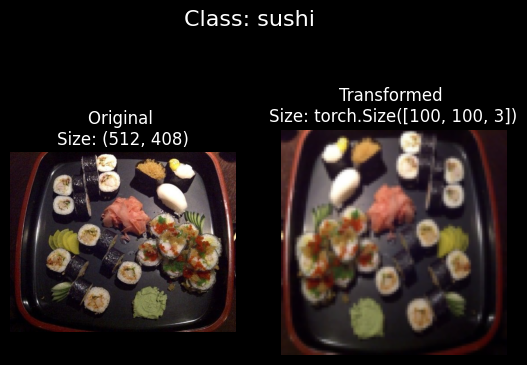

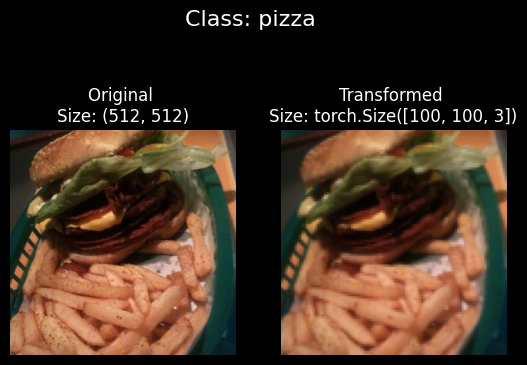

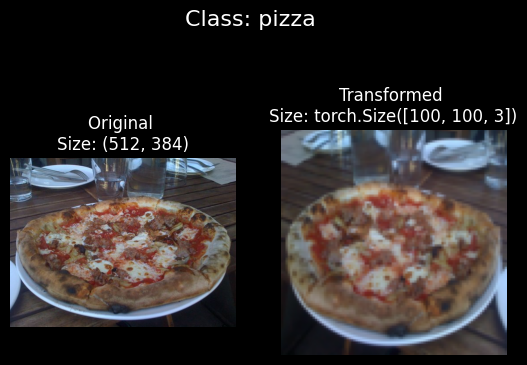

In [10]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Loading Image Data using `ImageFolder`

trhence we  have created an transformer for the image for
1. To convert into Tensor
2. to flip horizotally
3. to resize image

now convert that image to an format that PyTorch can use

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder for conversion
                                  transform=data_transform, # transforms to perform on images
                                  target_transform=None) # transforms to perform on Labels

test_data = datasets.ImageFolder(root=test_dir,  # target folder for conversion
                                 transform=data_transform)  # transforms to perform on images

print(f"train_data:{train_data}")
print("=" * 100 )
print(f"test_data:{test_data}")

train_data:Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
test_data:Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )


lets check our data set through some operations

In [12]:
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data),len(test_data)

(225, 75)

total 225 data for training and 75 for testing

In [15]:
img , label = train_data[0][0] , train_data[0][1]
print(f"image : {img}")
print(f"label : {label}")
print(f"image datatype : {img.dtype}")

print(f"image shape: {img.shape}")

image : tensor([[[0.1137, 0.1137, 0.1137,  ..., 0.1059, 0.1098, 0.1137],
         [0.1294, 0.1255, 0.1294,  ..., 0.0980, 0.1059, 0.1098],
         [0.1333, 0.1294, 0.1333,  ..., 0.0941, 0.0980, 0.1059],
         ...,
         [0.1725, 0.1647, 0.1647,  ..., 0.0980, 0.0902, 0.0863],
         [0.1765, 0.1647, 0.1686,  ..., 0.0902, 0.0863, 0.0863],
         [0.1647, 0.1608, 0.1608,  ..., 0.0863, 0.0863, 0.0902]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0706, 0.0706, 0.0706],
         [0.0667, 0.0627, 0.0627,  ..., 0.0745, 0.0745, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0706, 0.0745, 0.0706],
         ...,
         [0.2353, 0.2314, 0.2431,  ..., 0.1176, 0.1176, 0.1098],
         [0.2314, 0.2275, 0.2353,  ..., 0.1059, 0.1059, 0.1059],
         [0.2275, 0.2275, 0.2392,  ..., 0.1020, 0.1020, 0.1059]],

        [[0.0235, 0.0196, 0.0196,  ..., 0.0902, 0.0941, 0.0941],
         [0.0235, 0.0196, 0.0235,  ..., 0.0902, 0.0902, 0.0941],
         [0.0157, 0.0157, 0.0157,  ..., 0.0863, 0.

How about we plot a single image tensor using matplotlib?

We'll first have  to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

original image permuted : torch.Size([3, 100, 100])
permuted image permuted : torch.Size([100, 100, 3])


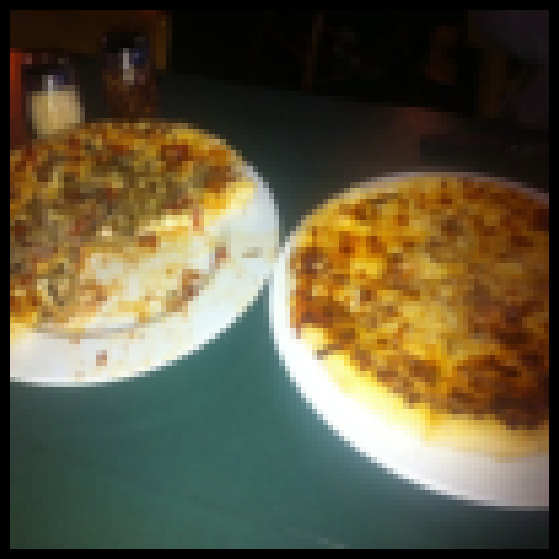

In [16]:
# permute the image ( change in Dimension )
img_permute = img.permute(1, 2, 0)

# print out diffrent shapes ( before and afterv permute )
print(f"original image permuted : {img.shape}")
print(f"permuted image permuted : {img_permute.shape}")
# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.show()

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,
                          batch_size=1, # how many samples per batch?
                          num_workers=1, # # how many subprocesses to use for data loading? (higher = more)
                          shuffle=True)

test_dataloader = DataLoader(test_data,
                         batch_size=1,
                         num_workers=1,
                         shuffle=True)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16f937533b0>,
 <torch.utils.data.dataloader.DataLoader at 0x16f95f1df70>)

# Other forms of transforms (data augmentation)


**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

The idea behind TrivialAugment is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

In [18]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),

])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out

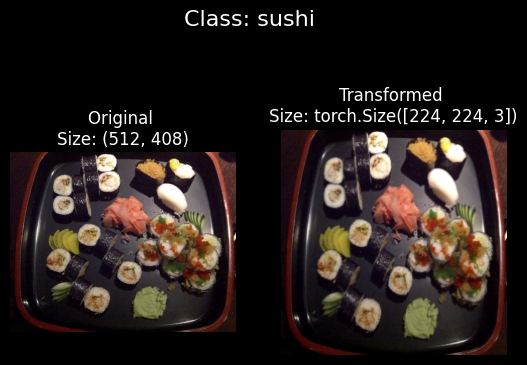

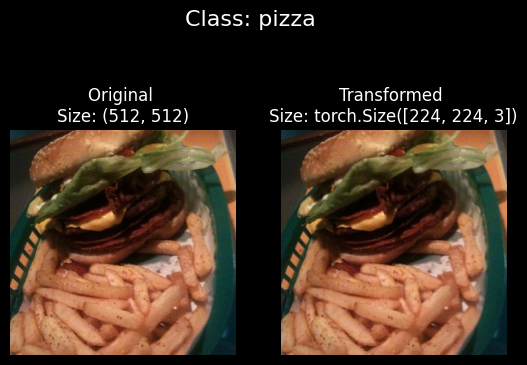

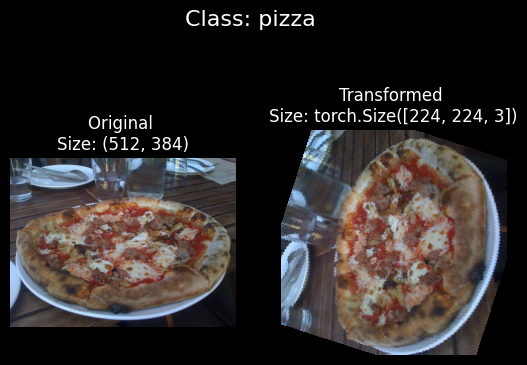

In [19]:
# get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# plot the random images
plot_transformed_images(
    image_path_list,
    transform=train_transforms,
    n=3,
    seed=42
)

# model 0 : TinyVGG Without data augmentation

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors

In [20]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`


Then into a DataLoader using `torch.utils.data.DataLoader()`.


We'll set the batch_size=32 and num_workers to as many CPUs on our machine (this will depend on what machine you're using)

In [21]:
train_data_simple = datasets.ImageFolder(root = train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, transform=simple_transform)

# 2 turn data loader into Dataloader
import os
Batch_Size = 32
NUM_WORKERS = os.cpu_count()

print(f"Creating DataLoader's with batch size {Batch_Size} and {NUM_WORKERS} workers.")
# create dataloader

train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=Batch_Size,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=Batch_Size,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_simple,test_dataloader_simple

Creating DataLoader's with batch size 32 and 20 workers.


(<torch.utils.data.dataloader.DataLoader at 0x16f96027b90>,
 <torch.utils.data.dataloader.DataLoader at 0x16f96026c00>)

## create an TinyVGG model class

In [22]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape :int ,output_shape : int ,hidden_units : int) -> None:
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
            x = self.conv_block_1(x)
        # print(x.shape)
            x = self.conv_block_2(x)
        # print(x.shape)
            x = self.classifier(x)
        # print(x.shape)
            return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

Get a batch of images and labels from the DataLoader.

Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).

Perform inference on a single image (making sure to send the image to the target device).

Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax()

In [23]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [24]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

nice the `torchinfo.summary()` gives the whole info about the model , layer by layer


## create Train & test loop

Specifically, we're going to make three functions:

1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary

In [25]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

To keep track of the number of epochs we've been through, let's import tqdm from tqdm.auto (tqdm is one of the most popular progress bar libraries for Python and tqdm.auto automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [27]:
from tqdm.auto import tqdm

# take in various parameter required for training and test set
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5 ):
    # create empty result dictonary
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []}
     # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4 print out what is happeneing
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

C:\PyTorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As for an optimizer and loss function, we'll use torch.nn.CrossEntropyLoss() (since we're working with multi-class classification data) and torch.optim.Adam() with a learning rate of 1e-3 respectively.

To see how long things take, we'll import Python's timeit.default_timer() method to calculate the training time.

In [28]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:16<02:32, 16.99s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604


 20%|██        | 2/10 [00:34<02:19, 17.46s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979


 30%|███       | 3/10 [00:53<02:07, 18.25s/it]

Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979


 40%|████      | 4/10 [01:14<01:55, 19.29s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1343 | test_acc: 0.1979


 50%|█████     | 5/10 [01:37<01:43, 20.64s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1435 | test_acc: 0.1979


 60%|██████    | 6/10 [01:59<01:23, 20.88s/it]

Epoch: 6 | train_loss: 1.0964 | train_acc: 0.3086 | test_loss: 1.1483 | test_acc: 0.2604


 70%|███████   | 7/10 [02:22<01:04, 21.51s/it]

Epoch: 7 | train_loss: 1.1184 | train_acc: 0.3281 | test_loss: 1.1418 | test_acc: 0.2917


 80%|████████  | 8/10 [02:43<00:42, 21.49s/it]

Epoch: 8 | train_loss: 1.1013 | train_acc: 0.3594 | test_loss: 1.1048 | test_acc: 0.1979


 90%|█████████ | 9/10 [03:04<00:21, 21.27s/it]

Epoch: 9 | train_loss: 1.0891 | train_acc: 0.4844 | test_loss: 1.0692 | test_acc: 0.5417


100%|██████████| 10/10 [03:25<00:00, 20.55s/it]

Epoch: 10 | train_loss: 1.0693 | train_acc: 0.4023 | test_loss: 1.0224 | test_acc: 0.5417
Total training time: 205.544 seconds


# model_1 with the Data augmentation

This time, let's load in the data and use data augmentation to see if it improves our results in anyway.

First, we'll compose a training transform to include transforms.TrivialAugmentWide() as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

In [29]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Now let's turn our images into Dataset's using torchvision.datasets.ImageFolder() and then into DataLoader's with torch.utils.data.DataLoader().

### Create train and test Dataset's and DataLoader's


In [30]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir,
                                            transform=train_transform_trivial_augment)

test_data_simple = datasets.ImageFolder(test_dir,
                                        transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make DataLoader's with a batch_size=32 and with num_workers set to the number of CPUs available on our machine (we can get this using Python's os.cpu_count()).

In [31]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16f9135bf50>,
 <torch.utils.data.dataloader.DataLoader at 0x16f95f1df70>)

### Construct and train Model 1


In [32]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Since we've already got functions for the training loop (train_step()) and testing loop (test_step()) and a function to put them together in train(), let's reuse those.

We'll use the same setup as model_0 with only the train_dataloader parameter varying:

* Train for 5 epochs.
* Use train_dataloader=train_dataloader_augmented as the training data in train().
* Use torch.nn.CrossEntropyLoss() as the loss function (since we're working with multi-class classification).
* Use torch.optim.Adam() with lr=0.001 as the learning rate as the optimizer.

In [33]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:21<01:27, 21.92s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604


 40%|████      | 2/5 [00:43<01:04, 21.54s/it]

Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604


 60%|██████    | 3/5 [01:05<00:43, 21.77s/it]

Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604


 80%|████████  | 4/5 [01:26<00:21, 21.76s/it]

Epoch: 4 | train_loss: 1.1287 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604


100%|██████████| 5/5 [01:47<00:00, 21.55s/it]

Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 107.720 seconds


#  Make a prediction on a custom image
